# BEMB Demo: Simulation Studies.

> Author: Tianyu Du (tianyudu@stanford.edu)

This notebook contains replication materials for the simulation studies in the BEMB paper;

Before running this notebook, you should create a folder called, to save simulation results (e.g., figures). Please modify the `OUTPUT_DIR` variable below to point to the folder you just created.

In [1]:
import os
OUTPUT_DIR = "./paper_demo_simulation_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Setup.

In [2]:
# Standard library imports
import random
from typing import List

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from torch_choice.data import ChoiceDataset
from tqdm import tqdm

# Local imports
from bemb.model import LitBEMBFlex

In [3]:
# Fix Random Seeds for Reproducibility.
random.seed(1234)
np.random.seed(1234)
torch.random.manual_seed(1234)

In [4]:
# Please note that `mps` (apple silicon gpus) is not fully supported by PyTorch; therefore, you would need to use `cpu` device on Mac.
if torch.cuda.is_available():
    DEVICE = "cuda"
    try:
        # control the precision of GPU-based operations.
        torch.set_float32_matmul_precision("high")
    except:
        pass
else:
    DEVICE = "cpu"
print(f"Using {DEVICE} device with torch version {torch.__version__} and name {torch.cuda.get_device_name(DEVICE)}")

Using cuda device with torch version 2.5.1+cu124 and name NVIDIA GeForce RTX 3090


In [5]:
# control the quality of figures. Use 75 for preview, use 300 for publication.
# using a larger DPI will increase the file size of the figure and the time to render the figure.
DPI = 300

In [6]:
# configure the size of simulation.
num_users = 1_500  # 1500 users in the dataset.
num_items = 50  # 50 items to choose from.
num_sessions = 10  # 10 sessions; sessions are used only in simulation 4.
data_size = 50_000  # 10,000 choice records.

# New Simulation Studies introduced in 2025 Revision.

Preview of simulated purchase records:
|    |   user |   item |   user_cluster |   item_cluster |     M_ui |   f_M_ui |     P_ui |     U_ui |
|---:|-------:|-------:|---------------:|---------------:|---------:|---------:|---------:|---------:|
|  0 |     63 |     47 |              1 |              1 | 2071.68  |  7.6366  |  33.9116 | 1785.19  |
|  1 |    365 |     47 |              4 |              1 |  106.755 |  4.67986 |  24.9202 | -305.093 |
|  2 |    971 |     47 |              1 |              1 | 1481.25  |  7.30131 |  26.8484 | 1020.56  |
|  3 |    613 |     47 |              2 |              1 | -640.136 | -6.46324 | -10.5085 |  481.151 |
|  4 |    748 |     47 |              0 |              1 | 1979.58  |  7.59114 |  36.3718 |  669.638 |


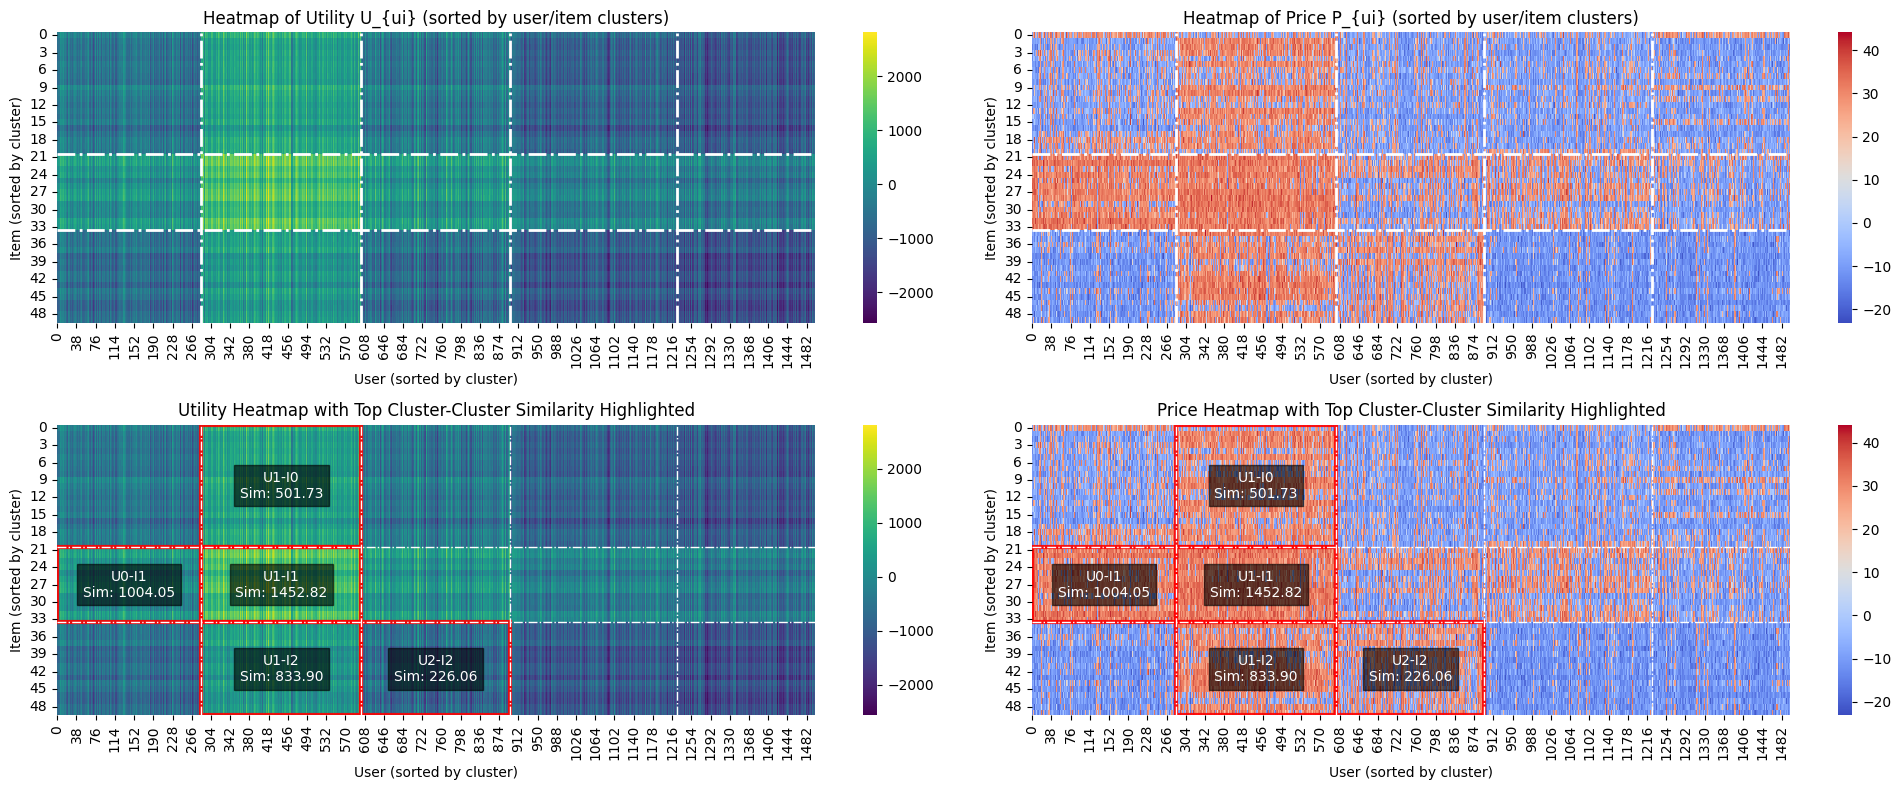

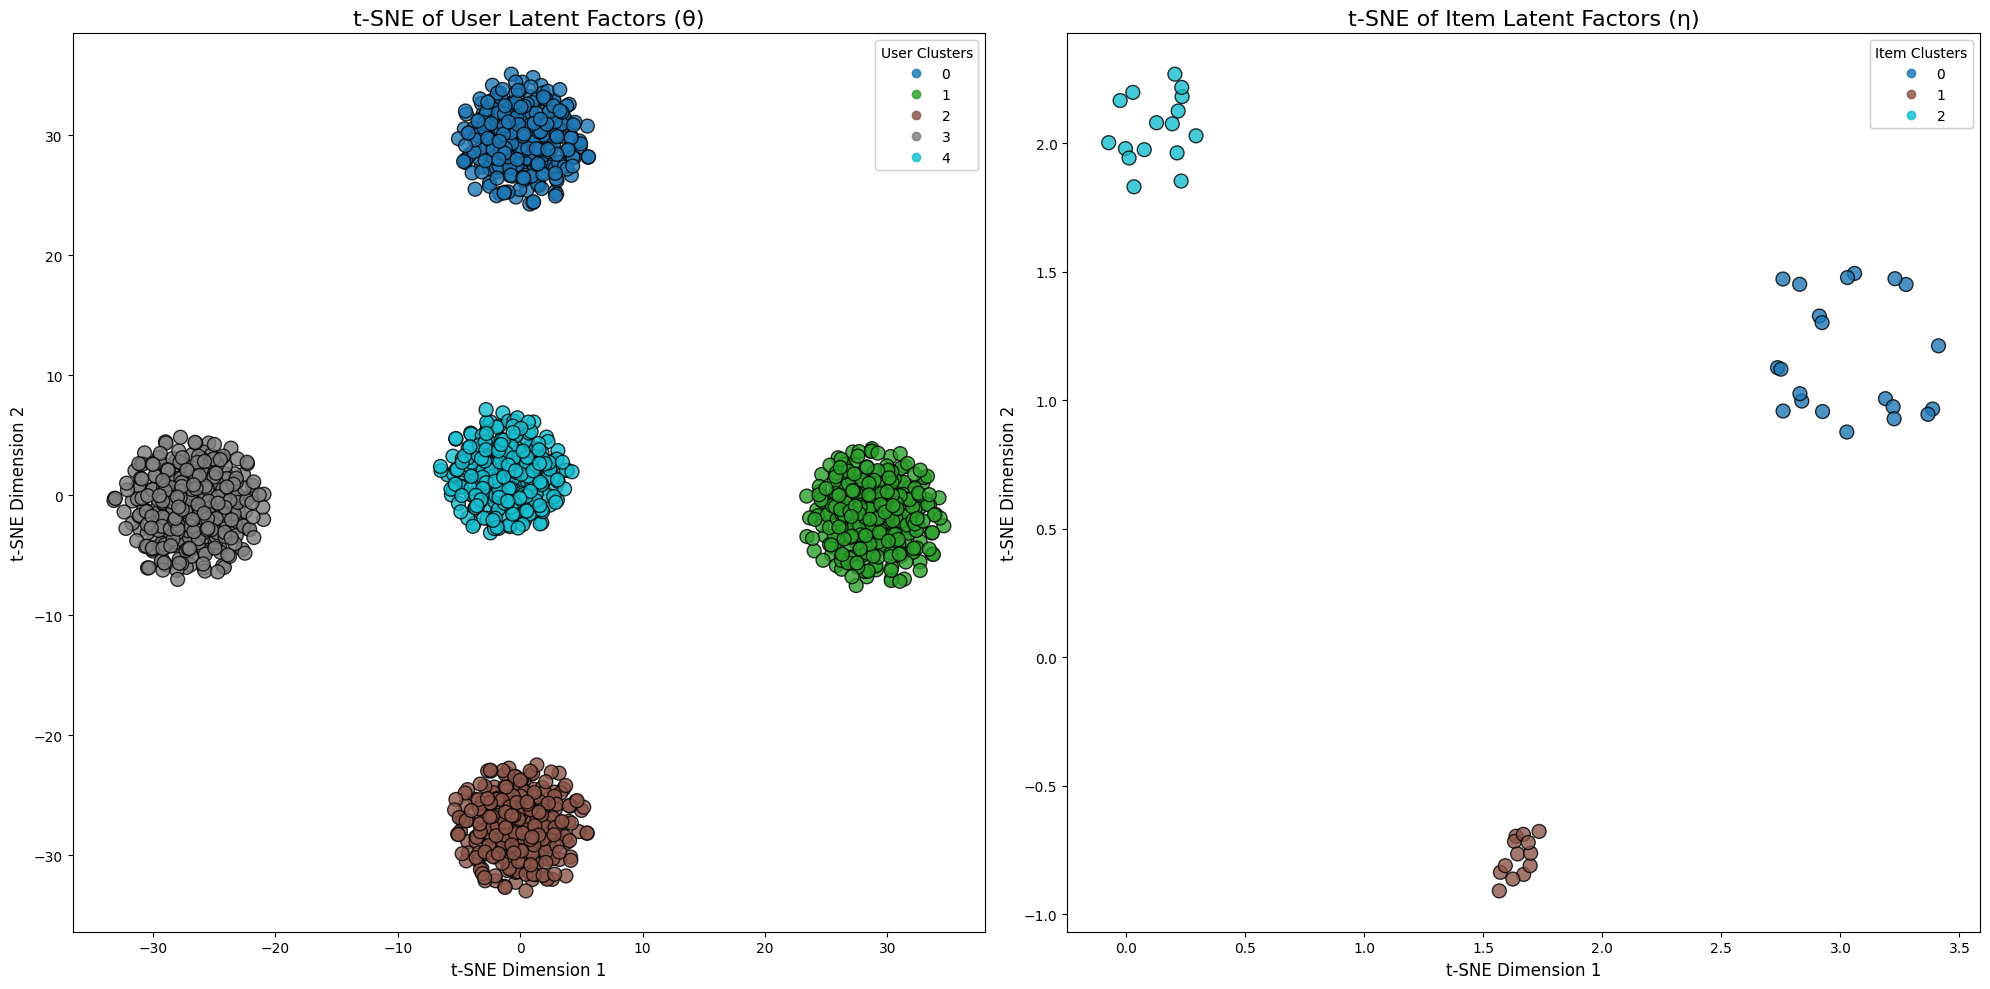

In [7]:
# Set the number of clusters
K_u = 5        # number of user clusters.
K_i = 3        # number of item clusters.
R = 50         # latent dimension in the data generation process.

# Variance parameters for clusters and within-cluster noise
sigma_cluster_u = 10   # std dev for user cluster means.
sigma_user = 10        # within-user-cluster noise std dev for latent factors.
sigma_cluster_i = 10   # std dev for item cluster means.
sigma_item = 5        # within-item-cluster noise std dev for latent factors.

# Utility generation parameters
gamma = -3.5        # coefficient on the personalized offer (i.e., price) in the utility function.
sigma_U = 0.8       # noise std dev for the utility.

# Parameter for personalize price (offer) generation
delta_0 = 10
delta_1 = 3
sigma_P = 3


# Generate user cluster assignments and user latents.
user_clusters = np.random.choice(K_u, size=num_users)
user_cluster_assignments = user_clusters  # Create variable for t-SNE visualization
cluster_means_users = np.random.normal(0, sigma_cluster_u, size=(K_u, R))
theta = np.array([
    cluster_means_users[user_clusters[u]] + np.random.normal(0, sigma_user, size=R)
    for u in range(num_users)
])

# Generate item cluster assignments and item latents.
item_clusters = np.random.choice(K_i, size=num_items)
item_cluster_assignments = item_clusters  # Create variable for t-SNE visualization
cluster_means_items = np.random.normal(0, sigma_cluster_i, size=(K_i, R))
eta = np.array([
    cluster_means_items[item_clusters[i]] + np.random.normal(0, sigma_item, size=R)
    for i in range(num_items)
])

# Compute M_{ui} = <theta_u, eta_i> user item interaction.
M = theta.dot(eta.T)  # shape: (num_users, num_items)

# Add some non-linear transformations to make interactions more complex.
def nonlinear_transform(x):
    return np.sign(x) * np.log(1 + np.abs(x))

# Apply nonlinear transformation to interaction matrix
F_M = nonlinear_transform(M)

# -------------------------------
# 3. Generate the Personalized Offer P_{ui} as a Nonlinear Function of M_{ui}
# -------------------------------
# Generate the personalized offer with additional complexity:
# Add quadratic terms to make it more complex
P = delta_0 + delta_1 * F_M + np.random.normal(0, sigma_P, size=(num_users, num_items))

# -------------------------------
# 4. Generate Fixed Effects for Users and Items using average of M
# -------------------------------
# Instead of random fixed effects, use the average of M for each user/item
alpha = np.mean(M, axis=1)  # user fixed effects - average across items.
beta = np.mean(M, axis=0)   # item fixed effects - average across users.

# -------------------------------
# 5. Generate the Utility Matrix U with Strong Interaction Effects
# -------------------------------
# U_{ui} = alpha_u + beta_i + gamma * P_{ui} + noise.
# The interaction term is now weighted more heavily than the fixed effects
U = (alpha[:, np.newaxis] + beta[np.newaxis, :]
     + gamma * P
     + np.random.normal(0, sigma_U, size=(num_users, num_items)))

# -------------------------------
# 6. Sample Purchase Records via a Softmax over U
# -------------------------------
def softmax(x):
    ex = np.exp(x - np.max(x))
    return ex / np.sum(ex)

# randomly sample users to take action.
sampled_users = np.random.choice(num_users, size=data_size, replace=True)
# create placeholder for items.
sampled_items = np.empty(data_size, dtype=int)

for idx, u in enumerate(sampled_users):
    # Sample using the full utility model
    probs = softmax(U[u, :])
    sampled_items[idx] = np.random.choice(num_items, p=probs)


records = {
    'user': sampled_users,
    'item': sampled_items,
    'user_cluster': user_clusters[sampled_users],
    'item_cluster': item_clusters[sampled_items],
    'M_ui': M[sampled_users, sampled_items],
    'f_M_ui': F_M[sampled_users, sampled_items],
    'P_ui': P[sampled_users, sampled_items],
    'U_ui': U[sampled_users, sampled_items]
}
df_purchases = pd.DataFrame(records)

print("Preview of simulated purchase records:")
print(df_purchases.head().to_markdown())

# -------------------------------
# 7. Visualize the Utility Matrix U and Price Matrix P as Heatmaps (Sorted by Clusters) with Boundary Lines
# -------------------------------

# Sort users and items by their cluster assignments
sorted_user_indices = np.argsort(user_clusters)
sorted_item_indices = np.argsort(item_clusters)
U_sorted = U[sorted_user_indices, :][:, sorted_item_indices]
P_sorted = P[sorted_user_indices, :][:, sorted_item_indices]

# Determine boundaries for clusters
sorted_user_clusters = user_clusters[sorted_user_indices]
user_boundaries = np.where(np.diff(sorted_user_clusters) != 0)[0]
sorted_item_clusters = item_clusters[sorted_item_indices]
item_boundaries = np.where(np.diff(sorted_item_clusters) != 0)[0]

# Calculate similarity between user cluster centers and item cluster centers
user_item_cluster_similarity = cluster_means_users @ cluster_means_items.T  # Shape: (K_u, K_i)

# Find the top N pairs with highest similarity
N = 5  # Number of top pairs to highlight
flat_indices = np.argsort(user_item_cluster_similarity.flatten())[-N:]  # Get indices of top N values
top_pairs = np.array(np.unravel_index(flat_indices, user_item_cluster_similarity.shape)).T  # Convert to (user_cluster, item_cluster) pairs

# Create a figure with four subplots in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 8))

# First subplot: Utility heatmap
sns.heatmap(U_sorted.T, cmap="viridis", cbar=True, ax=ax1)
ax1.set_xlabel("User (sorted by cluster)")
ax1.set_ylabel("Item (sorted by cluster)")
ax1.set_title("Heatmap of Utility U_{ui} (sorted by user/item clusters)")

# Add boundary lines to utility heatmap
for boundary in user_boundaries:
    ax1.axvline(x=boundary+1, color='white', linestyle='-.', linewidth=2)
for boundary in item_boundaries:
    ax1.axhline(y=boundary+1, color='white', linestyle='-.', linewidth=2)

# Second subplot: Price heatmap
sns.heatmap(P_sorted.T, cmap="coolwarm", cbar=True, ax=ax2)
ax2.set_xlabel("User (sorted by cluster)")
ax2.set_ylabel("Item (sorted by cluster)")
ax2.set_title("Heatmap of Price P_{ui} (sorted by user/item clusters)")

# Add boundary lines to price heatmap
for boundary in user_boundaries:
    ax2.axvline(x=boundary+1, color='white', linestyle='-.', linewidth=2)
for boundary in item_boundaries:
    ax2.axhline(y=boundary+1, color='white', linestyle='-.', linewidth=2)

# Third subplot: Highlighted top similarity cluster boxes for utility
sns.heatmap(U_sorted.T, cmap="viridis", cbar=True, ax=ax3)
ax3.set_xlabel("User (sorted by cluster)")
ax3.set_ylabel("Item (sorted by cluster)")
ax3.set_title("Utility Heatmap with Top Cluster-Cluster Similarity Highlighted")

# Add boundary lines
for boundary in user_boundaries:
    ax3.axvline(x=boundary+1, color='white', linestyle='-.', linewidth=1)
for boundary in item_boundaries:
    ax3.axhline(y=boundary+1, color='white', linestyle='-.', linewidth=1)

# Fourth subplot: Highlighted top similarity cluster boxes for price
sns.heatmap(P_sorted.T, cmap="coolwarm", cbar=True, ax=ax4)
ax4.set_xlabel("User (sorted by cluster)")
ax4.set_ylabel("Item (sorted by cluster)")
ax4.set_title("Price Heatmap with Top Cluster-Cluster Similarity Highlighted")

# Add boundary lines
for boundary in user_boundaries:
    ax4.axvline(x=boundary+1, color='white', linestyle='-.', linewidth=1)
for boundary in item_boundaries:
    ax4.axhline(y=boundary+1, color='white', linestyle='-.', linewidth=1)

# Helper structures to find cluster boundaries
user_boundaries_with_end = np.append(np.insert(user_boundaries, 0, -1), len(sorted_user_clusters)-1)
item_boundaries_with_end = np.append(np.insert(item_boundaries, 0, -1), len(sorted_item_clusters)-1)

# Highlight only the top similarity boxes in both utility and price heatmaps
for user_cluster_id, item_cluster_id in top_pairs:
    # Find which segment this user cluster occupies
    u_idx = np.where(np.unique(sorted_user_clusters) == user_cluster_id)[0][0]
    u_start = user_boundaries_with_end[u_idx] + 1
    u_end = user_boundaries_with_end[u_idx+1] + 1

    # Find which segment this item cluster occupies
    i_idx = np.where(np.unique(sorted_item_clusters) == item_cluster_id)[0][0]
    i_start = item_boundaries_with_end[i_idx] + 1
    i_end = item_boundaries_with_end[i_idx+1] + 1

    # Draw rectangles around this high-similarity cluster-cluster box in both heatmaps
    rect_utility = plt.Rectangle((u_start, i_start), u_end-u_start, i_end-i_start,
                       fill=False, edgecolor='red', linewidth=3, alpha=0.9)
    ax3.add_patch(rect_utility)

    rect_price = plt.Rectangle((u_start, i_start), u_end-u_start, i_end-i_start,
                       fill=False, edgecolor='red', linewidth=3, alpha=0.9)
    ax4.add_patch(rect_price)

    # Add cluster IDs and similarity score in the center of the boxes
    similarity = user_item_cluster_similarity[user_cluster_id, item_cluster_id]
    ax3.text(u_start + (u_end-u_start)/2, i_start + (i_end-i_start)/2,
            f"U{user_cluster_id}-I{item_cluster_id}\nSim: {similarity:.2f}",
            ha='center', va='center', color='white',
            bbox=dict(facecolor='black', alpha=0.6))

    ax4.text(u_start + (u_end-u_start)/2, i_start + (i_end-i_start)/2,
            f"U{user_cluster_id}-I{item_cluster_id}\nSim: {similarity:.2f}",
            ha='center', va='center', color='white',
            bbox=dict(facecolor='black', alpha=0.6))

plt.tight_layout()
plt.show()

# Create t-SNE visualization of user and item latent factors
# Set up the figure for t-SNE plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# t-SNE for user latent factors (theta)
tsne_user = TSNE(n_components=2, random_state=42, perplexity=30)
theta_embedded = tsne_user.fit_transform(theta)

# Create a scatter plot for users, colored by cluster
scatter1 = ax1.scatter(
    theta_embedded[:, 0],
    theta_embedded[:, 1],
    c=user_cluster_assignments,
    cmap='tab10',
    alpha=0.8,
    s=100,
    edgecolor='k'
)

# Add legend for user clusters
legend1 = ax1.legend(*scatter1.legend_elements(),
                    title="User Clusters",
                    loc="upper right")
ax1.add_artist(legend1)
ax1.set_title('t-SNE of User Latent Factors (θ)', fontsize=16)
ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)

# t-SNE for item latent factors (eta)
tsne_item = TSNE(n_components=2, random_state=42, perplexity=30)
eta_embedded = tsne_item.fit_transform(eta)

# Create a scatter plot for items, colored by cluster
scatter2 = ax2.scatter(
    eta_embedded[:, 0],
    eta_embedded[:, 1],
    c=item_cluster_assignments,
    cmap='tab10',
    alpha=0.8,
    s=100,
    edgecolor='k'
)

# Add legend for item clusters
legend2 = ax2.legend(*scatter2.legend_elements(),
                    title="Item Clusters",
                    loc="upper right")
ax2.add_artist(legend2)
ax2.set_title('t-SNE of Item Latent Factors (η)', fontsize=16)
ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)

plt.tight_layout()
plt.show()


In [8]:
# Create a ChoiceDataset using only the df_purchases DataFrame
import torch
from torch_choice.data import ChoiceDataset

# Convert user and item indices to PyTorch tensors
user_index = torch.LongTensor(df_purchases['user'].values)
item_index = torch.LongTensor(df_purchases['item'].values)

# Create session indices (one session per purchase record)
session_index = torch.arange(len(df_purchases), dtype=torch.long)

# Extract the purchase-specific features from df_purchases
user_cluster = torch.LongTensor(df_purchases['user_cluster'].values)
item_cluster = torch.LongTensor(df_purchases['item_cluster'].values)
M_ui = torch.FloatTensor(df_purchases['M_ui'].values)
f_M_ui = torch.FloatTensor(df_purchases['f_M_ui'].values)
P_ui = torch.FloatTensor(df_purchases['P_ui'].values)
U_ui = torch.FloatTensor(df_purchases['U_ui'].values)

# Create a tensor containing all the user-item pair features
usersessionitem_obs = torch.stack([
    user_cluster.float(),
    item_cluster.float(),
    M_ui,
    f_M_ui,
    P_ui,
    U_ui
], dim=1)

# Create the ChoiceDataset with explicit user, item, and session counts
dataset_nonlinear = ChoiceDataset(
    user_index=user_index,
    item_index=item_index,
    session_index=session_index,
    # Explicitly specify the number of users, items, and sessions
    num_users=num_users,
    num_items=num_items,
    num_sessions=data_size,  # Since we have one session per purchase record
    # All items are available
    item_availability=None,
    # Add the usersessionitem observation tensor
    usersessionitem_obs=usersessionitem_obs
)

print(dataset_nonlinear)

# Split into train, validation, and test sets
def split_dataset_into_train_val_test(D):
    # Split dataset into train, val, test
    idx = np.random.permutation(len(D))
    train_size = int(0.8 * len(D))
    val_size = int(0.1 * len(D))
    train_idx = idx[:train_size]
    val_idx = idx[train_size: train_size + val_size]
    test_idx = idx[train_size + val_size:]

    dataset_list = [D[train_idx], D[val_idx], D[test_idx]]
    return dataset_list

# Split the dataset and move to appropriate device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

dataset_list = split_dataset_into_train_val_test(dataset_nonlinear)
dataset_list = [d.to(DEVICE) for d in dataset_list]

print(f"Training set: {len(dataset_list[0])} samples")
print(f"Validation set: {len(dataset_list[1])} samples")
print(f"Test set: {len(dataset_list[2])} samples")

ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[50000], user_index=[50000], session_index=[50000], item_availability=[], usersessionitem_obs=[50000, 6], device=cpu)
Training set: 40000 samples
Validation set: 5000 samples
Test set: 5000 samples


Basic statistics for item choices:
Total number of purchases: 50000
Number of unique items chosen: 4 out of 50 possible items
Average purchases per item: 1000.00
Minimum purchases for an item: 728
Maximum purchases for an item: 44400


Top 10 most frequently chosen items:
    Count  Percentage
47  44400      88.800
15   2979       5.958
33   1893       3.786
18    728       1.456


Top 10 least frequently chosen items:
    Count  Percentage
18    728       1.456
33   1893       3.786
15   2979       5.958
47  44400      88.800




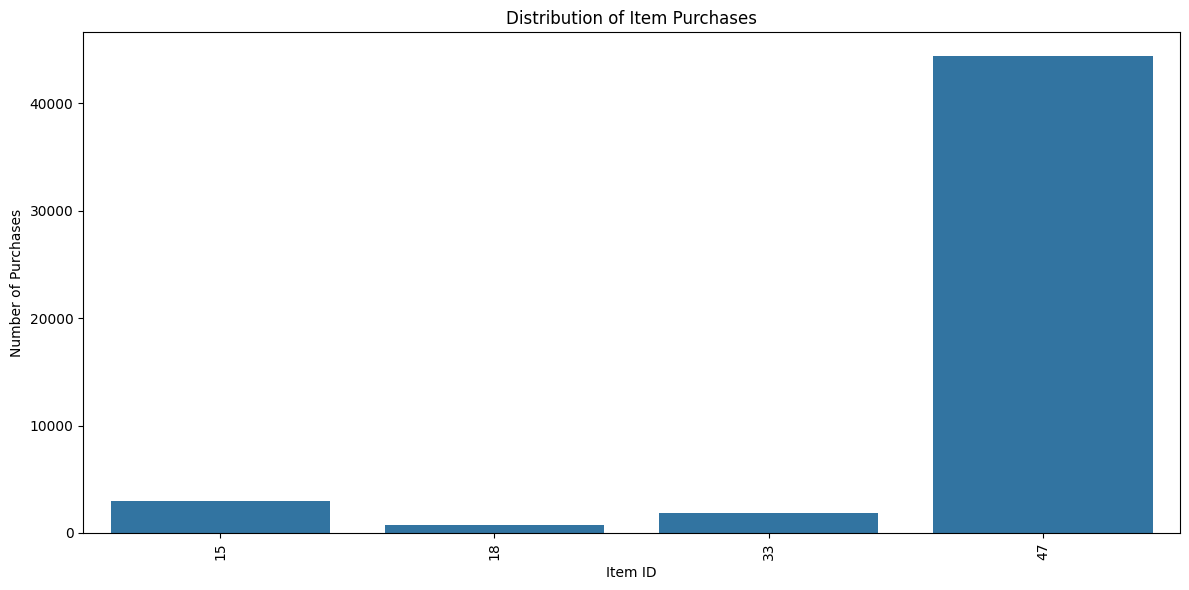

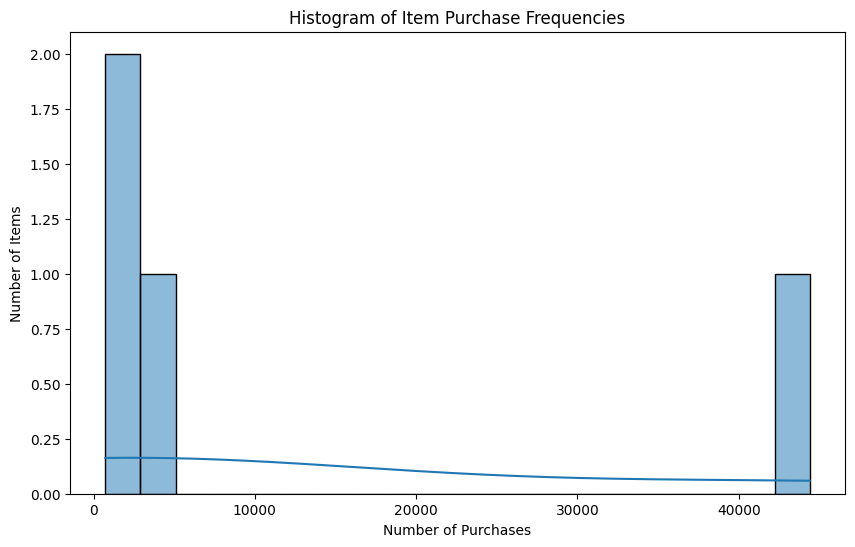

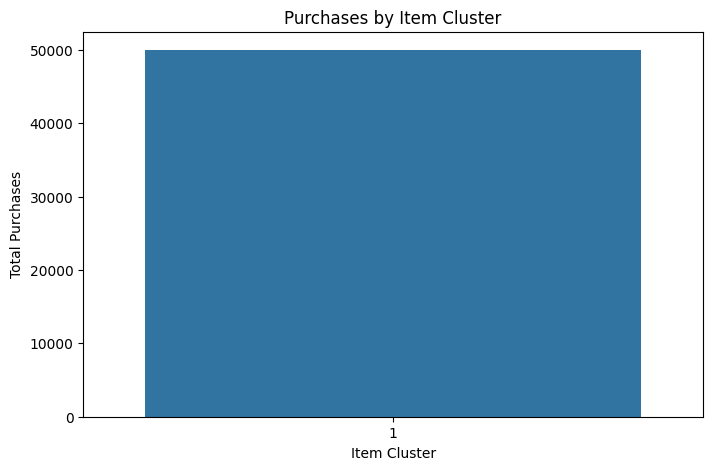

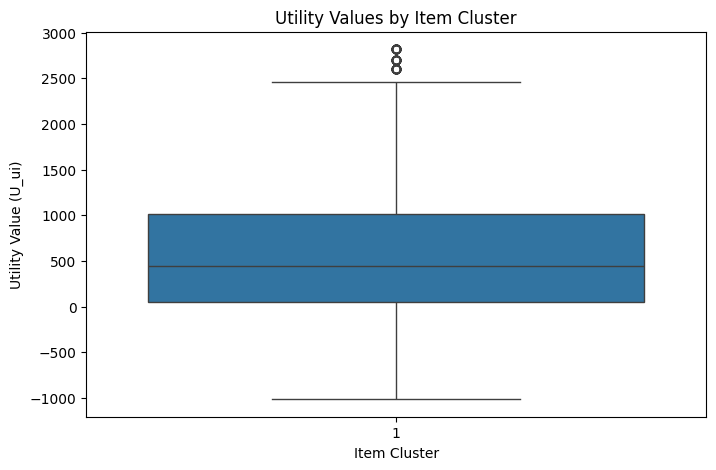

In [9]:
# Summary statistics for items chosen in the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Count frequency of each item
item_counts = pd.Series(df_purchases['item'].values).value_counts()
item_percentages = 100 * item_counts / len(df_purchases)

# Create a dataframe for better visualization
item_stats = pd.DataFrame({
    'Count': item_counts,
    'Percentage': item_percentages
}).sort_index()

# Add summary statistics
print("Basic statistics for item choices:")
print(f"Total number of purchases: {len(df_purchases)}")
print(f"Number of unique items chosen: {len(item_counts)} out of {num_items} possible items")
print(f"Average purchases per item: {len(df_purchases) / num_items:.2f}")
print(f"Minimum purchases for an item: {item_counts.min()}")
print(f"Maximum purchases for an item: {item_counts.max()}")
print("\n")

# Most popular items
print("Top 10 most frequently chosen items:")
most_popular = item_stats.sort_values('Count', ascending=False).head(10)
print(most_popular)
print("\n")

# Least popular items
print("Top 10 least frequently chosen items:")
least_popular = item_stats.sort_values('Count').head(10)
print(least_popular)
print("\n")

# Visualize the distribution with a bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=item_stats.index, y='Count', data=item_stats)
plt.xlabel('Item ID')
plt.ylabel('Number of Purchases')
plt.title('Distribution of Item Purchases')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a histogram of purchase counts
plt.figure(figsize=(10, 6))
sns.histplot(item_stats['Count'], bins=20, kde=True)
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Items')
plt.title('Histogram of Item Purchase Frequencies')
plt.show()

# Visualize relationship between item cluster and popularity
cluster_popularity = df_purchases.groupby('item_cluster')['item'].count().reset_index()
cluster_popularity.columns = ['Item Cluster', 'Total Purchases']

plt.figure(figsize=(8, 5))
sns.barplot(x='Item Cluster', y='Total Purchases', data=cluster_popularity)
plt.title('Purchases by Item Cluster')
plt.show()

# Check if certain utility values lead to more purchases
plt.figure(figsize=(8, 5))
sns.boxplot(x='item_cluster', y='U_ui', data=df_purchases)
plt.title('Utility Values by Item Cluster')
plt.xlabel('Item Cluster')
plt.ylabel('Utility Value (U_ui)')
plt.show()

In [11]:
# Ignore UserWarning about y_pred values not summing to one
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The y_pred values do not sum to one")


MAX_EPOCHS = 500
records = []

for utility_formula, latent_dim in [
    ('alpha_user + beta_item', None),
    ('alpha_constant + beta_item', None),
    ('alpha_user + beta_item + gamma_user * delta_item', 2),
    ('alpha_user + beta_item + gamma_user * delta_item', 5),
    ('alpha_user + beta_item + gamma_user * delta_item', 10),
    ('alpha_user + beta_item + gamma_user * delta_item', 30),
]:
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO, smaller number for faster training, more samples for better gradient estimation.
        utility_formula=utility_formula,
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'alpha_user': False, 'alpha_constant': False,'beta_item': False, 'gamma_user': False, 'delta_item': False},
        # the dimension of beta_item, which is 1.
        coef_dim_dict={'alpha_user': 1, 'alpha_constant': 1, 'beta_item': 1, 'gamma_user': latent_dim, 'delta_item': latent_dim},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb, stats = bemb.fit_model(
        split_dataset_into_train_val_test(dataset_nonlinear),
        # full batch training.
        batch_size=len(dataset_nonlinear)//5, num_epochs=MAX_EPOCHS, num_workers=8, early_stopping_patience=3, device=DEVICE, enable_progress_bar=False, visualize_learning_curves=False)

    records.append((utility_formula, latent_dim, stats))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 3.1 K 
-----------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item
Total number of parameters: 3100.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40000], session_index=[40000], item_availability=[], usersessionitem_obs=[50000, 6], device=cpu)
[Validation dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[5000], user_index=[5000], session_index=[5000], item_avai

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 194.91495370864868
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8858000040054321     │
│          test_ll          │   -0.47262686491012573    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 102   
-----------------------------------
102       Trainable params
0         Non-trainable params
102       Total params
0.000     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_constant'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_constant + beta_item
Total number of parameters: 102.
With the following coefficients:
ModuleDict(
  (alpha_constant): BayesianCoefficient(num_classes=1, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40000], session_index=[40000], item_availability=[], usersessionitem_obs=[50000, 6], device=cpu)
[Validation dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[5000], user_index=[5000], session_index=[5000], i

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 115.56649422645569
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8862000107765198     │
│          test_ll          │   -0.47669947147369385    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 9.3 K 
-----------------------------------
9.3 K     Trainable params
0         Non-trainable params
9.3 K     Total params
0.037     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 9300.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=2, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=2, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40000

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 44.96136522293091
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9976000189781189     │
│          test_ll          │   -0.012774098664522171   │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 18.6 K
-----------------------------------
18.6 K    Trainable params
0         Non-trainable params
18.6 K    Total params
0.074     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 18600.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=5, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=5, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[4000

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 20.564183473587036
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9983999729156494     │
│          test_ll          │   -0.003967229276895523   │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 34.1 K
-----------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.136     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 34100.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=10, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=10, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 17.994892597198486
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9986000061035156     │
│          test_ll          │   -0.012826367281377316   │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | BEMBFlex | 96.1 K
-----------------------------------
96.1 K    Trainable params
0         Non-trainable params
96.1 K    Total params
0.384     Total estimated model params size (MB)


BEMB: utility formula parsed:
[{'coefficient': ['alpha_user'], 'observable': None},
 {'coefficient': ['beta_item'], 'observable': None},
 {'coefficient': ['gamma_user', 'delta_item'], 'observable': None}]
==================== model received ====================
Bayesian EMBedding Model with U[user, item, session] = alpha_user + beta_item + gamma_user * delta_item
Total number of parameters: 96100.
With the following coefficients:
ModuleDict(
  (alpha_user): BayesianCoefficient(num_classes=1500, dimension=1, prior=N(0, I))
  (beta_item): BayesianCoefficient(num_classes=50, dimension=1, prior=N(0, I))
  (gamma_user): BayesianCoefficient(num_classes=1500, dimension=30, prior=N(0, I))
  (delta_item): BayesianCoefficient(num_classes=50, dimension=30, prior=N(0, I))
)
[]
Optimizer: Adam, Learning rate: 0.03
==================== data set received ====================
[Training dataset] ChoiceDataset(num_items=50, num_users=1500, num_sessions=50000, label=[], item_index=[40000], user_index=[40

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


time taken: 14.48646330833435
==================== test performance ====================


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9991999864578247     │
│          test_ll          │   -0.001194890239275992   │
└───────────────────────────┴───────────────────────────┘

In [26]:
from typing import List, Tuple, Dict, Optional, Any
import matplotlib.pyplot as plt
import numpy as np
import re

def format_utility_formula(formula: str) -> str:
    """
    Convert utility formula to a prettier format with Greek letters.

    Args:
        formula: A utility formula string like 'alpha_user + beta_item'

    Returns:
        A formatted string with Greek letters and proper subscripts
    """
    # Define mapping of parameter names to Greek letters with subscripts
    greek_mapping = {
        'alpha_user': r'$\alpha_{user}$',
        'alpha_constant': r'$\alpha$',
        'alpha_item': r'$\alpha_{item}$',
        'beta_user': r'$\beta_{user}$',
        'beta_item': r'$\beta_{item}$',
        'gamma_user': r'$\gamma_{user}$',
        'gamma_item': r'$\gamma_{item}$',
        'delta_user': r'$\delta_{user}$',
        'delta_item': r'$\delta_{item}$',
        'theta_user': r'$\theta_{user}$',
        'eta_item': r'$\eta_{item}$',
        'pi_user': r'$\pi_{user}$',
    }

    # Replace parameter names with their Greek equivalents
    for param, greek in greek_mapping.items():
        formula = formula.replace(param, greek)

    # Format operators
    formula = formula.replace(' * ', ' · ')

    return formula

def visualize_model_results(
    records: List[Tuple[str, Optional[int], Dict[str, Any]]]
) -> Tuple[plt.Figure, plt.Axes]:
    """
    Visualize the training, validation, and test results from multiple model configurations.
    Shows negative log-likelihood for validation and test metrics (lower is better for all plots).

    Args:
        records: List of tuples (utility_formula, latent_dim, stats) with model results

    Returns:
        Tuple containing (figure, axes) for further customization if needed
    """
    # Create descriptive labels for each model with Greek letter formatting
    model_labels = []
    for utility_formula, latent_dim, _ in records:
        formatted_formula = format_utility_formula(utility_formula)
        if latent_dim is None:
            model_labels.append(f"{formatted_formula}")
        else:
            model_labels.append(f"{formatted_formula} (dim={latent_dim})")

    # Color map for consistent colors across plots
    colors = plt.cm.tab10(np.linspace(0, 1, len(records)))

    # Create a single figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=300)

    # Subplot 1: Training ELBO by epochs
    for i, (_, _, stats) in enumerate(records):
        epochs = range(1, len(stats['train_elbo']) + 1)
        axes[0].plot(epochs, stats['train_elbo'], marker='o', markersize=4,
                     linewidth=0.8, color=colors[i], label=model_labels[i])

    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Training ELBO')
    axes[0].set_title('Training ELBO\n(lower is better)')
    axes[0].grid(True, linestyle='--', alpha=0.7)

    # Subplot 2: Negative Validation Log-Likelihood by epochs
    for i, (_, _, stats) in enumerate(records):
        epochs = range(1, len(stats['val_ll']) + 1)
        # Negate val_ll to show negative log-likelihood
        axes[1].plot(epochs, [-ll for ll in stats['val_ll']], marker='s', markersize=4,
                     linewidth=0.8, color=colors[i], label=model_labels[i])

    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Negative Validation Log-Likelihood')
    axes[1].set_title('Negative Validation Log-Likelihood\n(lower is better)')
    axes[1].grid(True, linestyle='--', alpha=0.7)

    # Subplot 3: Negative Test Log-Likelihood for each model
    # Negate test_ll to show negative log-likelihood
    test_neg_ll_values = [-stats['test_ll'].item() for _, _, stats in records]

    bars = axes[2].bar(range(len(model_labels)), test_neg_ll_values, color=colors, width=0.7)

    # Add value labels on top of bars
    for bar, val in zip(bars, test_neg_ll_values):
        height = bar.get_height()
        axes[2].annotate(f'{val:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=0)

    axes[2].set_xlabel('Model Configuration')
    axes[2].set_ylabel('Negative Test Log-Likelihood')
    axes[2].set_title('Negative Test Log-Likelihood\n(lower is better)')
    axes[2].set_xticks(range(len(model_labels)))
    axes[2].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[2].grid(True, linestyle='--', alpha=0.7, axis='y')

    # Add a vertically stacked legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper center',  # Position at the center
               bbox_to_anchor=(0.5, 0.30),  # Position below the plots
               ncol=1,  # Stack items vertically (one column)
               fancybox=True,
               shadow=True,
               frameon=True)

    plt.tight_layout()
    # Adjust bottom margin to make room for the vertically stacked legend
    plt.subplots_adjust(bottom=0.20 + 0.03*len(records))  # Scale based on number of items

    return fig, axes

(<Figure size 6000x1800 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Training ELBO\n(lower is better)'}, xlabel='Epochs', ylabel='Training ELBO'>,
        <AxesSubplot: title={'center': 'Negative Validation Log-Likelihood\n(lower is better)'}, xlabel='Epochs', ylabel='Negative Validation Log-Likelihood'>,
        <AxesSubplot: title={'center': 'Negative Test Log-Likelihood\n(lower is better)'}, xlabel='Model Configuration', ylabel='Negative Test Log-Likelihood'>],
       dtype=object))

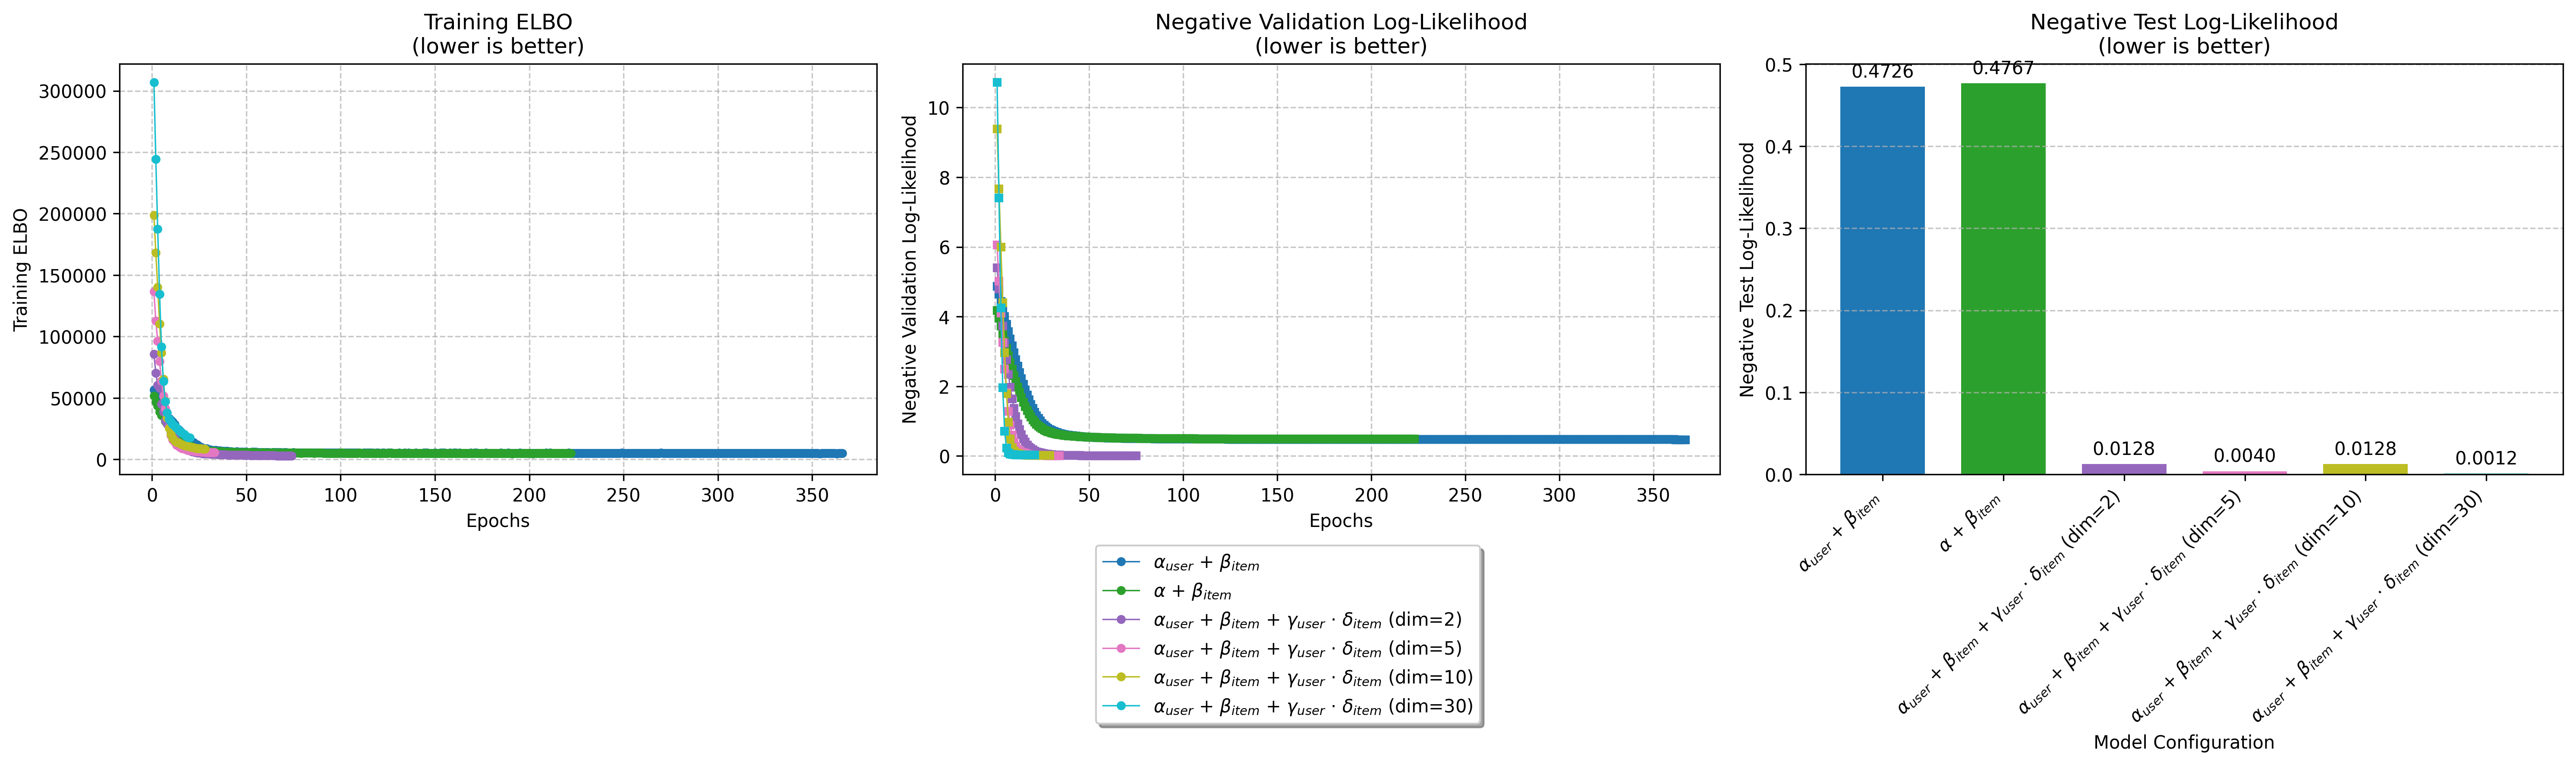

In [27]:
visualize_model_results(records=records)

# [JUMP HERE]

# Previous Simulation Studies.

In [7]:
# we assign random users and sessions to each choice record.
user_index = torch.LongTensor(np.random.choice(num_users, size=data_size))
session_index = torch.LongTensor(np.random.choice(num_sessions, size=data_size))

In [8]:
# a helper function to plot distributions of entries in a tensor.
def plot_tensor(tensor):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=DPI)
    sns.histplot(tensor.view(-1,).numpy(), bins=40, ax=ax)
    fig.show()

# Simulation Study 1: Item-Level "Random" Effect on User Attributes

## Simulate Dataset
We first specify the number of users and number of items in the dataset.
The `data_size` denotes the number of user-item choice pairs to generate (i.e., number of observations.)
Each user-item choice pair is called a **purchasing record** in our terminology, you can revise the data management tutorial.

In [ ]:
# generate random user income data.
user_income = (torch.randn(num_users) + 5).clamp(min=0)
# plot the histogram of user income.
plot_tensor(user_income)

In [ ]:
# generate item price data.
item_price = torch.rand(num_items) * 50 + 50
# plot distribution of item prices.
plot_tensor(item_price)
# WLOG, assign the first 25 items to be in the same category (category 1), and the rest to be in the other category (category 0).
item_bin_cate = torch.zeros(num_items).long()
item_bin_cate[:25] = 1

# combine both information into a tensor of shape (num_items, 2).
item_obs = torch.stack([item_price, item_bin_cate], dim=1)

## Generate Item-Specific Random Coefficients and Utilities.
In our first simulation case, the utility $\mu_{uis}$ is a function of user-income with item-specific coefficient.

$$
\mu_{uis} = \beta_i \times x^\text{user income}_u
$$

The item-specific coefficient $\beta_i$ is generated as a stochastic function of item prices. For high price items, income boost utility (e.g., luxury items). For low price items, low income boost utility. Please refer to the BEMB paper for a more detailed description of the simulation setup.

In [ ]:
# generate $beta_i$ for simulation study.
scaled_price = (item_price - torch.min(item_price))/ (torch.max(item_price) - torch.min(item_price)) - 0.5
beta_item = torch.randn_like(scaled_price)*torch.std(scaled_price) + scaled_price

# plot the relationship between $price_i$ and $beta_i$.
fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, 'simulation_1_income_coefficients.png'), dpi=DPI, bbox_inches='tight')
fig.show()

In [12]:
# compute the utility $\mu_{uis}$ for each user $u$, item $i$, and session $s$.
# there is no session effect in this simulation study, hence $\mu_{uis}$ is the same for all $s$.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in range(num_users):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]

In [ ]:
# distribution of U*I*S utility entries.
plot_tensor(utility)

## Generate Random Choices based on Utilities.

In [14]:
item_index = torch.empty(data_size, dtype=torch.long)
for idx in range(data_size):
    # get the user and session index corresponding to each choice record.
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]  # list of utility values for all items in the session.
    p = torch.softmax(utility_list, dim=0).numpy()  # soft-max transform utilities to probabilities in multinominal distribution.
    assert abs(np.sum(p) - 1) < 1e-5  # check if the sum of probabilities is 1.
    # randomly choose an item from the multinominal distribution with probabilities p.
    item_index[idx] = np.random.choice(num_items, p=p)

In [15]:
def report_most_least_bought_items(item_index: torch.LongTensor):
    # report most bought and least bought items.
    vc = pd.DataFrame(data={"item": item_index.squeeze().numpy()}).value_counts(normalize=True).sort_values(ascending=False)
    print("Most bought item with their frequencies:")
    print(vc.head())
    print("Least bought item with their frequencies:")
    print(vc.tail())

## Build Choice Dataset
Please refer to our `torch-choice` paper for more details.

In [16]:
def split_dataset_into_train_val_test(D: ChoiceDataset) -> List[ChoiceDataset]:
    # split dataset into train, val, test.
    idx = np.random.permutation(len(D))
    train_size = int(0.8 * len(D))
    val_size = int(0.1 * len(D))
    train_idx = idx[:train_size]
    val_idx = idx[train_size: train_size + val_size]
    test_idx = idx[train_size + val_size:]

    dataset_list = [D[train_idx], D[val_idx], D[test_idx]]
    return dataset_list

In [ ]:
dataset_1 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate).to(DEVICE)

print(dataset_1)

## Fit A Model

In [ ]:
# def fit_model(obs2prior: bool):
LATENT_DIM = 10  # the dimension of alpha and theta.
bemb = LitBEMBFlex(
    model_optimizer="Adam",
    learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
    pred_item=True,  # let the model predict item_index, don't change this one.
    num_seeds=128,  # number of Monte Carlo samples for estimating the ELBO.
    utility_formula='beta_item * user_income',  # the utility formula.
    num_users=num_users,
    num_items=num_items,
    trace_log_q=True,
    # whether to turn on obs2prior for each parameter.
    obs2prior_dict={'beta_item': False},
    # the dimension of beta_item, which is 1.
    coef_dim_dict={'beta_item': 1},
)

# use GPU if available.
bemb = bemb.to(DEVICE)

# use the provided run helper to train the model.
# we set batch size to be 5% of the data size, and train the model for 10 epochs.
# there would be 20*10=200 gradient update steps in total.
bemb = bemb.fit_model(
    split_dataset_into_train_val_test(dataset_1),
    batch_size=256, num_epochs=3, num_workers=0, device=DEVICE, enable_progress_bar=False)

## Comparison between $\beta_i$ and $\hat{\beta}_i$ for items.

In [ ]:
# actual beta_i's
real = beta_item.squeeze().numpy()
# prediction from the fitted variational distribution.
pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

print(f"{real.shape=:}, {pred.shape=:}")
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
ax.scatter(np.arange(num_items), real, label="beta", marker="o", color="blue")
ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")

ax.set_xlabel("Item Index")
ax.set_ylabel("Real and Estimated Coefficients")
ax.legend()
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_1_beta_hat.png"), dpi=DPI, bbox_inches="tight")
fig.show()

# Simulation Study 2: More Complicated Item-Specific Effects (Obs2Prior)

In [ ]:
# modify the beta_item based on the item category.
for i in range(num_items):
    if item_bin_cate[i] == 1:
        beta_item[i] = beta_item[i] + 3

fig, ax = plt.subplots(figsize=(8, 6), dpi=DPI)
sns.regplot(x=item_price.squeeze().numpy(), y=beta_item.numpy(), ax=ax)
ax.set_xlabel("$price_i$")
ax.set_ylabel("$beta_i$")
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_2_income_coefficients.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [ ]:
# recompute the utility matrix using the new coefficient.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = beta_item[i] * user_income[u]
# generate choices.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_index[idx] = np.random.choice(num_items, p=p)

In [ ]:
report_most_least_bought_items(item_index)

In [23]:
dataset_2 = ChoiceDataset(user_index=user_index,
                        item_index=item_index,
                        session_index=session_index,
                        item_availability=None,  # everything is available.
                        # observables.
                        user_income=user_income.view(num_users, 1),
                        item_price=item_price.view(num_items, 1),
                        item_bin_cate=item_bin_cate.view(num_items, 1),
                        item_obs=item_obs
                        ).to(DEVICE)

In [ ]:
# run two versions of the model with and without obs2prior.
for enable_obs2prior in [True, False]:
    # def fit_model(obs2prior: bool):
    LATENT_DIM = 10  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        model_optimizer="Adam",
        learning_rate=0.3,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='beta_item * user_income',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        trace_log_q=True,
        # num_user_obs=dataset.user_obs.shape[1],
        num_item_obs=dataset_2.item_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'beta_item': enable_obs2prior},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'beta_item': 1},
    )

    # use GPU if available.
    bemb = bemb.to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_2),
                          batch_size=128, num_epochs=40, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # plot the coefficients.
    real = beta_item.squeeze().numpy()
    pred = bemb.state_dict()["coef_dict.beta_item.variational_mean_flexible"].squeeze().numpy()
    err = 1.96 * bemb.state_dict()["coef_dict.beta_item.variational_logstd"].squeeze().exp()

    print(f"{real.shape=:}, {pred.shape=:}")
    fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)
    ax.scatter(np.arange(num_items), real, label="beta", marker="o")
    ax.scatter(np.arange(num_items), pred, label="beta-hat", marker="x")
    ax.errorbar(np.arange(num_items), y=pred, yerr=err, label="beta-hat", marker="x", linestyle='none', color="orange")
    ax.set_xlabel("Item Index")
    ax.set_ylabel("Real and Estimated Coefficients")
    ax.legend()

    if enable_obs2prior:
        ax.set_title("Item-Specific Coefficients with Obs2Prior")
    else:
        ax.set_title("Item-Specific Coefficients without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_2_beta_hat_obs2prior={enable_obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

# Simulation Study 3: User Latent and Item Latent Interactions

## User Specific Preferences

In [ ]:
Is = np.sin(np.arange(int(0.8*num_users)) / num_users * 4 * np.pi)
Is = (Is + 1) / 2 * num_items
Is = Is.astype(int)

Us = np.arange(num_users)
Is = np.concatenate([
    np.arange(int(0.2*num_users)) * num_items / (0.2*num_users),
    Is
])

PREFERENCE = dict((u, i) for (u, i) in zip(Us, Is))

# plot the preference
fig, ax = plt.subplots(figsize=(8, 3), dpi=DPI)
ax.scatter(Us, Is, s=0.3)
ax.set_xlabel('User Index')
ax.set_ylabel('Item Index $i^{like}(u)$')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_user_preferences.png"), dpi=DPI, bbox_inches='tight')
fig.show()

In [26]:
item_index = torch.LongTensor(np.random.choice(num_items, size=data_size))
user_bin_cate = torch.zeros(num_users).long()
# group users into two categories.
user_bin_cate[:100] = 1
user_bin_cate[200:num_users // 2] = 1

for idx in range(data_size):
    # follows random behaviors.
    rnd = np.random.rand()
    if user_bin_cate[int(user_index[idx])] == 0:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = PREFERENCE[int(user_index[idx])]
    else:
        if rnd <= 0.5:
            # choose based on preference with a probability of 0.5.
            item_index[idx] = num_items - PREFERENCE[int(user_index[idx])] - 1

To have a visual inspection on the preference we added, we can plot a heat map indexed by (user, item) and visualize the frequency of bought items by each user. In the heat map below, each row represents the empirical distribution of items (x-axis) bought. Warmer color (red) indicates high purchasing frequencies, which shows the synthetic sin-curve of preference we enforced above.

In [ ]:
df = pd.DataFrame(data={'item': item_index, 'user': user_index}).groupby(['item', 'user']).size().rename('size').reset_index()
df = df.pivot('item', 'user', 'size').fillna(0.0)

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(df.values, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Selected')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_3_heatmap.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [ ]:
# user_obs = torch.eye(num_users)
# user_obs = user_bin_cate.view(-1, 1)
# user_obs = torch.zeros(num_users, num_items)
# for u in range(num_users):
#     x = int(PREFERENCE[u])
#     if user_bin_cate[u] == 0:
#         user_obs[u, x] = 1
#     else:
#         user_obs[u, num_items - x - 1] = 1
# user_obs[torch.arange(num_users), Is] = 1
dataset_3 = ChoiceDataset(user_index=user_index, item_index=item_index, user_obs=torch.eye(num_users))

In [29]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_user_obs=dataset_3.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    )

    # use GPU if available.
    if torch.cuda.is_available():
        bemb = bemb.to('cuda')

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_3),
                          batch_size=128, num_epochs=100, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_3_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

In [ ]:
fit_model(obs2prior=True)

In [ ]:
fit_model(obs2prior=False)

# Simulation Study 4: User Latent and Item Latent Coefficient

In [32]:
magnitude = 5
theta = torch.empty(num_users, num_items)
for u in range(num_users):
    for i in range(num_items):
        diff = np.abs(i - (PREFERENCE[u])) / 100
        theta[u, i] = 1/(1 + np.exp(-diff))
        theta[u, i] = magnitude * theta[u, i] - 2.8

In [ ]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(theta.T, square=False, ax=ax, cmap='coolwarm')
ax.set(xlabel='User Index', ylabel='Item Index')
fig.savefig(os.path.join(OUTPUT_DIR, "simulation_4_coefficients.png"), dpi=DPI, bbox_inches="tight")
fig.show()

In [34]:
# generate random session observables.
session_obs = (torch.randn(num_sessions) + 1) * 100

In [ ]:
# recompute utilities.
utility = torch.zeros(num_users, num_items, num_sessions)
for u in tqdm(range(num_users)):
    for i in range(num_items):
        for s in range(num_sessions):
            utility[u, i, s] = theta[u, i] * session_obs[s]

# sample random choices as before.
item_index = torch.empty(data_size, dtype=torch.long)
for idx in tqdm(range(data_size)):
    u = user_index[idx]
    s = session_index[idx]
    utility_list = utility[u, :, s]
    p = torch.softmax(utility_list, dim=0).numpy()
    item_chosen = np.random.choice(num_items, p=p)
    item_index[idx] = item_chosen

# report most bought and least bought items.
report_most_least_bought_items(item_index)

In [36]:
user_obs = torch.zeros(num_users, num_items)
user_obs[torch.arange(num_users), Is] = 1

In [37]:
dataset_4 = ChoiceDataset(
    user_index=user_index,
    item_index=item_index,
    user_obs=user_obs,
    item_obs=item_obs,
    session_index=session_index,
    session_obs=session_obs.view(num_sessions, 1))

In [38]:
def fit_model(obs2prior: bool):
    LATENT_DIM = 5  # the dimension of alpha and theta.
    bemb = LitBEMBFlex(
        learning_rate=0.03,  # set the learning rate, feel free to play with different levels.
        pred_item=True,  # let the model predict item_index, don't change this one.
        num_seeds=32,  # number of Monte Carlo samples for estimating the ELBO.
        utility_formula='theta_user * alpha_item * session_obs',  # the utility formula.
        num_users=num_users,
        num_items=num_items,
        num_sessions=num_sessions,
        num_user_obs=dataset_4.user_obs.shape[1],
        # whether to turn on obs2prior for each parameter.
        obs2prior_dict={'theta_user': obs2prior, 'alpha_item': False},
        # the dimension of latents, since the utility is an inner product of theta and alpha, they should have
        # the same dimension.
        coef_dim_dict={'theta_user': LATENT_DIM, 'alpha_item': LATENT_DIM}
    ).to(DEVICE)

    # use the provided run helper to train the model.
    # we set batch size to be 5% of the data size, and train the model for 10 epochs.
    # there would be 20*10=200 gradient update steps in total.
    bemb = bemb.fit_model(split_dataset_into_train_val_test(dataset_4),
                          batch_size=128, num_epochs=300, num_workers=0, device=DEVICE, enable_progress_bar=False)

    # visualize the prediction.
    T = bemb.model.coef_dict['theta_user'].variational_mean_flexible.data
    A = bemb.model.coef_dict['alpha_item'].variational_mean_flexible.data
    fig, ax = plt.subplots(figsize=(18, 3))
    sns.heatmap((A @ T.T).numpy(), square=False, ax=ax, cmap='coolwarm')
    if obs2prior:
        ax.set_title("User-Item Interaction Utility with Obs2Prior")
    else:
        ax.set_title("User-Item Interaction Utility without Obs2Prior")
    fig.savefig(os.path.join(OUTPUT_DIR, f"simulation_4_interaction_hat_obs2prior={obs2prior}.png"), dpi=DPI, bbox_inches="tight")
    fig.show()

In [ ]:
fit_model(obs2prior=True)